In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from sklearn.calibration import calibration_curve

In [2]:
df = pd.read_parquet("results/medqa_gpt-3.5-turbo_atypical_base_all_01:18:19.parquet")

In [3]:
df.head()

,Questions,Difficulty Score,Mean Difficulty Score,Correct Answers,Majority Predicted Answer,All Predicted Answers,Final Prediction,Consistency Confidence,Average Vanilla Confidence,Average Confidence,All Vanilla Confidence Scores,All Confidence Scores,Ground Truth Probability
0,A 21-year-old sexually active male complains o...,[5],5.0,D,D,[D],D,1.0,1.0,1.0,[80],[80.0],1.0
1,A 5-year-old girl is brought to the emergency ...,[6],6.0,A,A,[A],A,1.0,1.0,1.0,[80],[77.47200894938749],1.0
2,A 40-year-old woman presents with difficulty f...,[3],3.0,E,C,[C],C,1.0,1.0,1.0,[90],[86.28405589149901],0.0
3,A 37-year-old female with a history of type II...,[4],4.0,C,C,[C],C,1.0,1.0,1.0,[90],[82.03682819057057],1.0
4,A 19-year-old boy presents with confusion and ...,[4],4.0,A,C,[C],C,1.0,1.0,1.0,[90],[84.94110848201957],0.0


In [8]:
def compute_atypical_scores(row):
    confidence_score = row['All Vanilla Confidence Scores'][0]
    calibrated_confidence = row['All Confidence Scores'][0]
    atypical_scores = np.log(calibrated_confidence / confidence_score) + 1
    return atypical_scores

In [9]:
df['Atypicality'] = df.apply(compute_atypical_scores, axis=1)

In [10]:
df.head()

,Questions,Difficulty Score,Mean Difficulty Score,Correct Answers,Majority Predicted Answer,All Predicted Answers,Final Prediction,Consistency Confidence,Average Vanilla Confidence,Average Confidence,All Vanilla Confidence Scores,All Confidence Scores,Ground Truth Probability,Atypicality
0,A 21-year-old sexually active male complains o...,[5],5.0,D,D,[D],D,1.0,1.0,1.0,[80],[80.0],1.0,1.000000
1,A 5-year-old girl is brought to the emergency ...,[6],6.0,A,A,[A],A,1.0,1.0,1.0,[80],[77.47200894938749],1.0,0.967890
2,A 40-year-old woman presents with difficulty f...,[3],3.0,E,C,[C],C,1.0,1.0,1.0,[90],[86.28405589149901],0.0,0.957835
3,A 37-year-old female with a history of type II...,[4],4.0,C,C,[C],C,1.0,1.0,1.0,[90],[82.03682819057057],1.0,0.907359
4,A 19-year-old boy presents with confusion and ...,[4],4.0,A,C,[C],C,1.0,1.0,1.0,[90],[84.94110848201957],0.0,0.942149


In [23]:
prob_true, prob_pred = calibration_curve(df['Ground Truth Probability'], df['All Vanilla Confidence Scores'].apply(lambda x: x[0]/100), n_bins=10)

In [27]:
prob_true_calibrated, prob_pred_calibrated = calibration_curve(df['Ground Truth Probability'], df['All Confidence Scores'].apply(lambda x: x[0]/100), n_bins=10)

In [24]:
prob_true

array([0.66666667, 0.44016227, 0.54220315, 0.5974026 ])

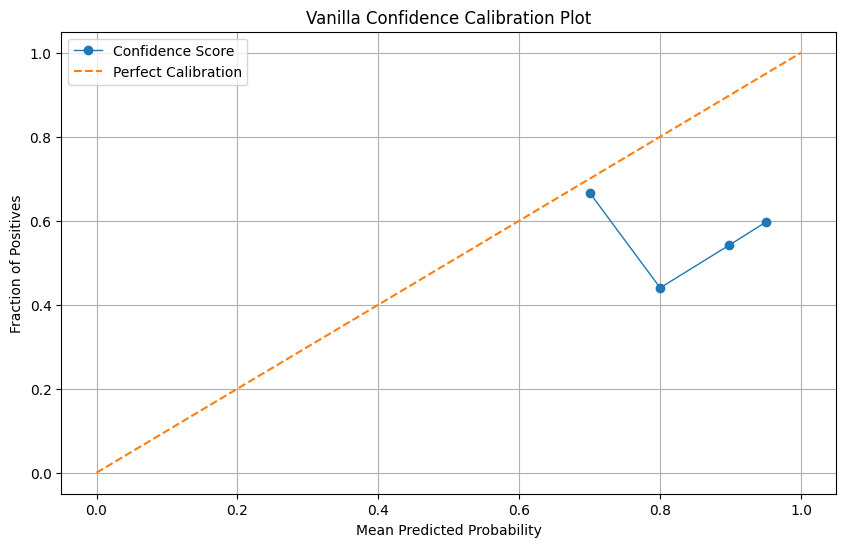

In [104]:
# Plot calibration curve
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Confidence Score')

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Vanilla Confidence Calibration Plot')
plt.legend()
plt.grid()
plt.show()

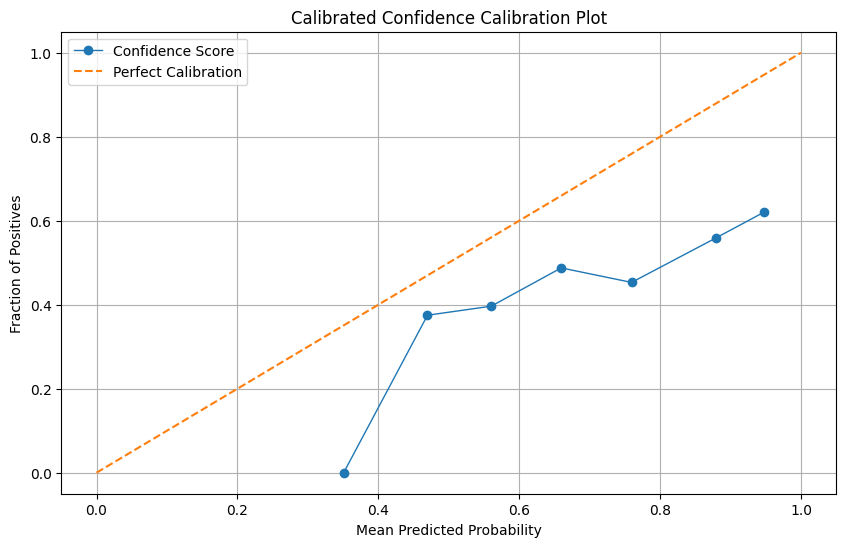

In [105]:
# Plot calibration curve
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', linewidth=1, label='Confidence Score')

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibrated Confidence Calibration Plot')
plt.legend()
plt.grid()
plt.show()

In [30]:
# Bin the atypicality scores
num_bins = 10
bins = np.linspace(df['Atypicality'].min(), df['Atypicality'].max(), num_bins + 1)
df['atypicality_bin'] = pd.cut(df['Atypicality'], bins, include_lowest=True)


In [32]:
df['accuracy'] = df['Ground Truth Probability']

/tmp/ipykernel_40988/173411979.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy = df.groupby('atypicality_bin')['accuracy'].mean()


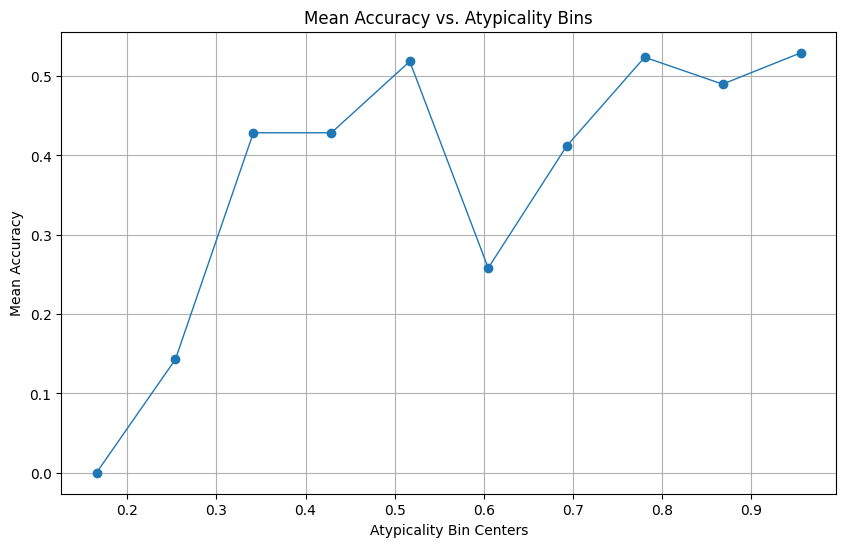

In [34]:
# Bin the atypicality scores
num_bins = 10
bins = np.linspace(df['Atypicality'].min(), df['Atypicality'].max(), num_bins + 1)
df['atypicality_bin'] = pd.cut(df['Atypicality'], bins, include_lowest=True)

# Calculate mean accuracy within each atypicality bin
mean_accuracy = df.groupby('atypicality_bin')['accuracy'].mean()

# Get the bin centers
bin_centers = [interval.mid for interval in mean_accuracy.index]

# Plot mean accuracy against atypicality bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, mean_accuracy.values, marker='o', linewidth=1)
plt.xlabel('Atypicality Bin Centers')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. Atypicality Bins')
plt.grid(True)
plt.show()

/tmp/ipykernel_40988/2848649569.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_accuracy = df.groupby('atypicality_bin')['accuracy'].mean()


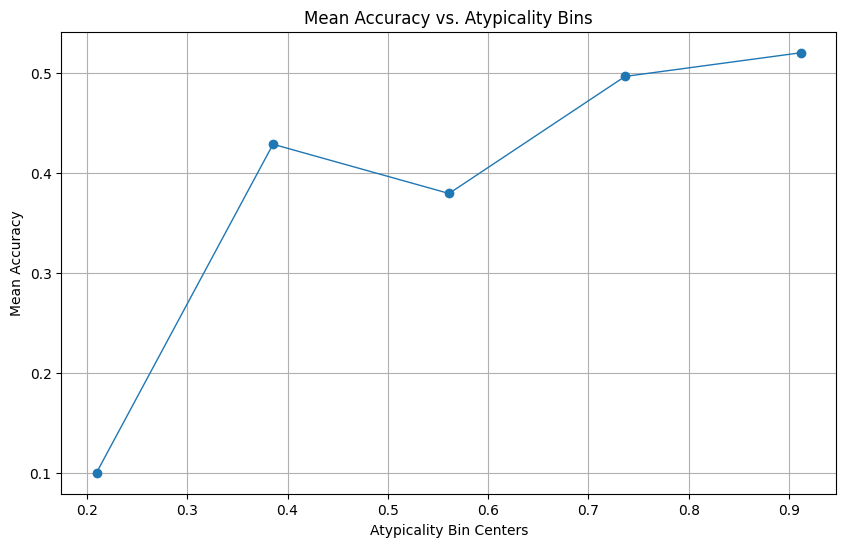

In [35]:
# Bin the atypicality scores
num_bins = 5
bins = np.linspace(df['Atypicality'].min(), df['Atypicality'].max(), num_bins + 1)
df['atypicality_bin'] = pd.cut(df['Atypicality'], bins, include_lowest=True)

# Calculate mean accuracy within each atypicality bin
mean_accuracy = df.groupby('atypicality_bin')['accuracy'].mean()

# Get the bin centers
bin_centers = [interval.mid for interval in mean_accuracy.index]

# Plot mean accuracy against atypicality bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, mean_accuracy.values, marker='o', linewidth=1)
plt.xlabel('Atypicality Bin Centers')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. Atypicality Bins')
plt.grid(True)
plt.show()

In [38]:
df['difficulty'] = df['Difficulty Score'].apply(lambda x: x[0])

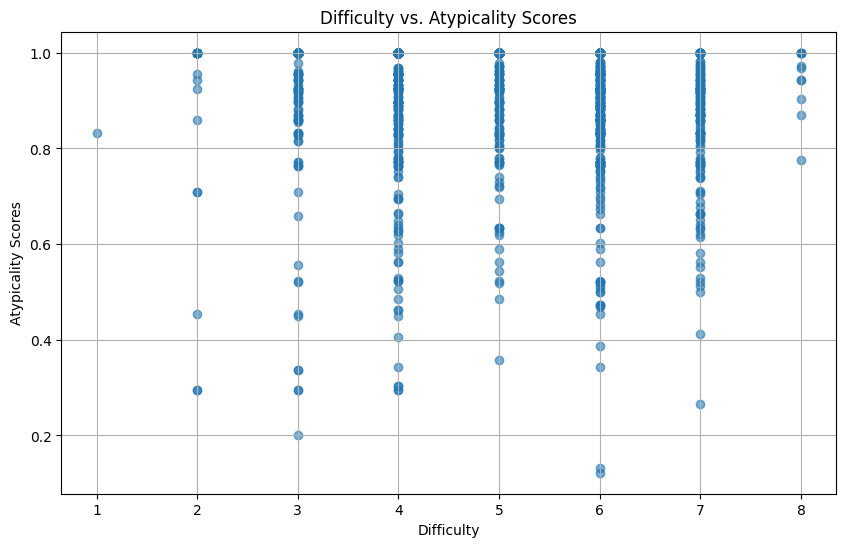

In [40]:
# Plot difficulty against atypicality scores
plt.figure(figsize=(10, 6))
plt.scatter(df['difficulty'], df['Atypicality'], alpha=0.6)
plt.xlabel('Difficulty')
plt.ylabel('Atypicality Scores')
plt.title('Difficulty vs. Atypicality Scores')
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

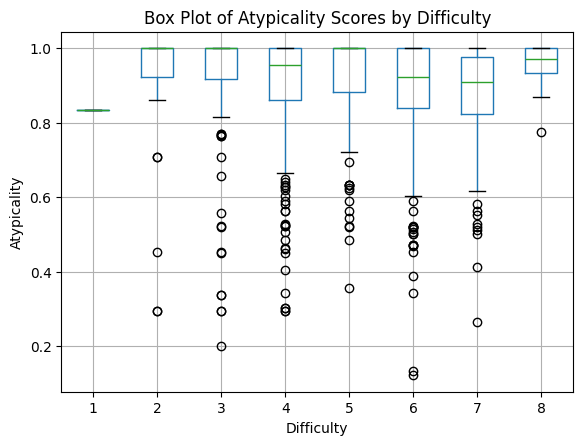

In [44]:
# Create box plot
plt.figure(figsize=(12, 6))
df.boxplot(column='Atypicality', by='difficulty', grid=False)
plt.xlabel('Difficulty')
plt.ylabel('Atypicality')
plt.title('Box Plot of Atypicality Scores by Difficulty')
plt.suptitle('')  # Suppress the automatic 'Boxplot grouped by...' title
plt.grid(True)
plt.show()

In [47]:
df['calibration_error'] = np.abs(df['All Confidence Scores'].apply(lambda x: x[0]/100) - df['accuracy'])

/tmp/ipykernel_40988/2407485656.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_atypicality = df.groupby('calibration_error_bin')['Atypicality'].mean()


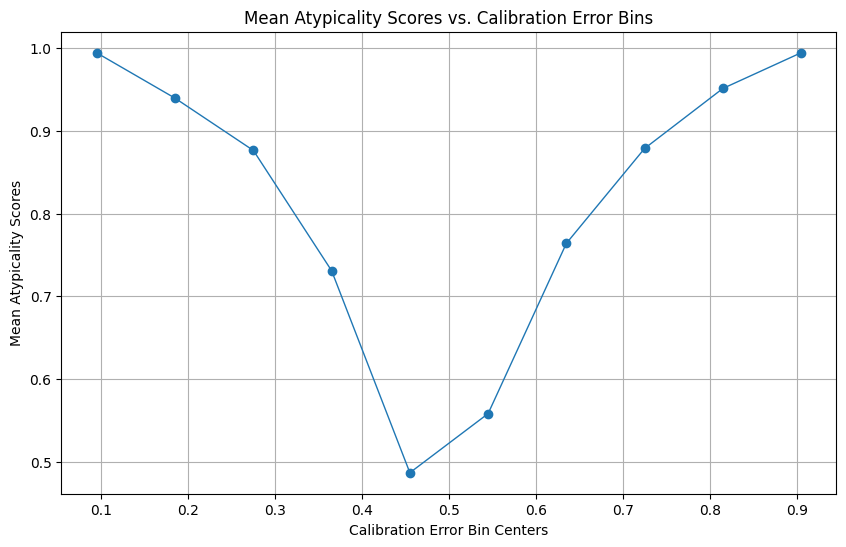

In [48]:
# Bin the calibration errors
num_bins = 10
bins = np.linspace(df['calibration_error'].min(), df['calibration_error'].max(), num_bins + 1)
df['calibration_error_bin'] = pd.cut(df['calibration_error'], bins, include_lowest=True)

# Calculate mean atypicality within each calibration error bin
mean_atypicality = df.groupby('calibration_error_bin')['Atypicality'].mean()

# Get the bin centers
bin_centers = [interval.mid for interval in mean_atypicality.index]

# Plot mean atypicality against calibration error bins
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, mean_atypicality.values, marker='o', linewidth=1)
plt.xlabel('Calibration Error Bin Centers')
plt.ylabel('Mean Atypicality Scores')
plt.title('Mean Atypicality Scores vs. Calibration Error Bins')
plt.grid(True)
plt.show()

In [51]:
df.head()

,Questions,Difficulty Score,Mean Difficulty Score,Correct Answers,Majority Predicted Answer,All Predicted Answers,Final Prediction,Consistency Confidence,Average Vanilla Confidence,Average Confidence,All Vanilla Confidence Scores,All Confidence Scores,Ground Truth Probability,Atypicality,atypicality_bin,accuracy,difficulty,calibration_error,calibration_error_bin
0,A 21-year-old sexually active male complains o...,[5],5.0,D,D,[D],D,1.0,1.0,1.0,[80],[80.0],1.0,1.000000,"(0.824, 1.0]",1.0,5,0.200000,"(0.14, 0.23]"
1,A 5-year-old girl is brought to the emergency ...,[6],6.0,A,A,[A],A,1.0,1.0,1.0,[80],[77.47200894938749],1.0,0.967890,"(0.824, 1.0]",1.0,6,0.225280,"(0.14, 0.23]"
2,A 40-year-old woman presents with difficulty f...,[3],3.0,E,C,[C],C,1.0,1.0,1.0,[90],[86.28405589149901],0.0,0.957835,"(0.824, 1.0]",0.0,3,0.862841,"(0.86, 0.95]"
3,A 37-year-old female with a history of type II...,[4],4.0,C,C,[C],C,1.0,1.0,1.0,[90],[82.03682819057057],1.0,0.907359,"(0.824, 1.0]",1.0,4,0.179632,"(0.14, 0.23]"
4,A 19-year-old boy presents with confusion and ...,[4],4.0,A,C,[C],C,1.0,1.0,1.0,[90],[84.94110848201957],0.0,0.942149,"(0.824, 1.0]",0.0,4,0.849411,"(0.77, 0.86]"


In [63]:
# Bin the atypicality scores into 5 bins
df['atypicality_bins'] = pd.qcut(df['Atypicality'], q=2, labels=False)

# Function to calculate ECE
def calculate_ece(confidences, labels):
    ece = np.abs(confidences.mean() - labels.mean())
    return ece

df['confidence_scores'] = df['All Confidence Scores'].apply(lambda x: x[0]/100)
# Calculate ECE for each bin
ece_per_bin = df.groupby('atypicality_bin').apply(
    lambda x: calculate_ece(x['confidence_scores'], x['Ground Truth Probability'])
).reset_index(name='ECE')

/tmp/ipykernel_40988/2417830647.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ece_per_bin = df.groupby('atypicality_bin').apply(


In [64]:
ece_per_bin

,atypicality_bin,ECE
0,"(0.121, 0.298]",0.322557
1,"(0.298, 0.473]",0.045556
2,"(0.473, 0.649]",0.162271
3,"(0.649, 0.824]",0.159388
4,"(0.824, 1.0]",0.310939


In [86]:
# Bin the atypicality scores into 5 bins
df['atypicality_bins_q'] = pd.qcut(df['Atypicality'], q=2, labels=None)

# Function to calculate ECE
def calculate_ece(confidences, labels):
    ece = np.abs(confidences.mean() - labels.mean())
    return ece

df['confidence_scores'] = df['All Confidence Scores'].apply(lambda x: x[0]/100)
# Calculate ECE for each bin
ece_per_bin = df.groupby('atypicality_bins_q').apply(
    lambda x: calculate_ece(x['confidence_scores'], x['Ground Truth Probability'])
).reset_index(name='ECE')

/tmp/ipykernel_40988/3348953987.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ece_per_bin = df.groupby('atypicality_bins_q').apply(


In [87]:
ece_per_bin

,atypicality_bins_q,ECE
0,"(0.121, 0.943]",0.216566
1,"(0.943, 1.0]",0.351537


In [89]:
data = {
    'atypicality_bin_q': ['(0.121, 0.943]', '(0.943, 1.0]'],
    'ECE': [0.216566, 0.351537]
}
ece_per_bin_q = pd.DataFrame(data)

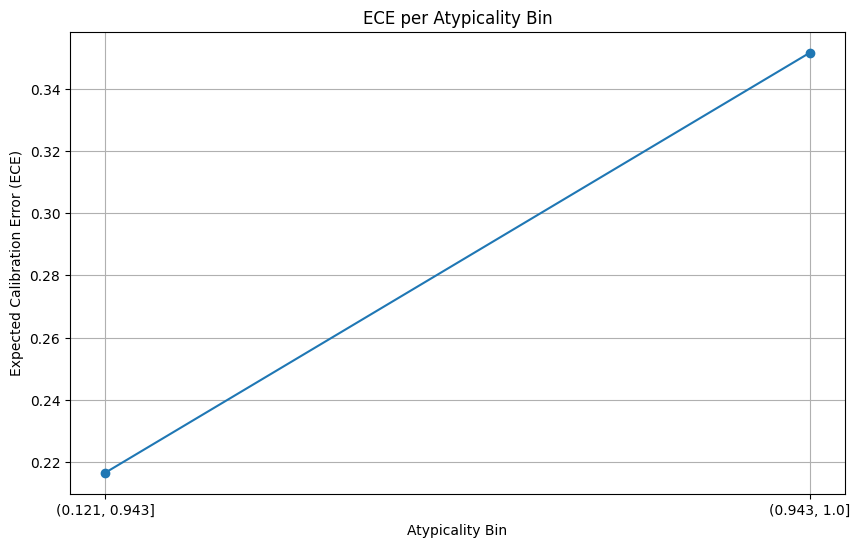

In [91]:
# Plotting the ECE per atypicality bin as a line chart
plt.figure(figsize=(10, 6))
plt.plot(ece_per_bin_q['atypicality_bin_q'], ece_per_bin_q['ECE'], marker='o', linestyle='-')
plt.xlabel('Atypicality Bin')
plt.ylabel('Expected Calibration Error (ECE)')
plt.title('ECE per Atypicality Bin')
plt.grid(True)
plt.show()

In [70]:
data = {
    'atypicality_bin': ['(0.121, 0.298]', '(0.298, 0.473]', '(0.473, 0.649]', '(0.649, 0.824]', '(0.824, 1.0]'],
    'ECE': [0.322557, 0.045556, 0.162271, 0.159388, 0.310939]
}
ece_per_bin = pd.DataFrame(data)

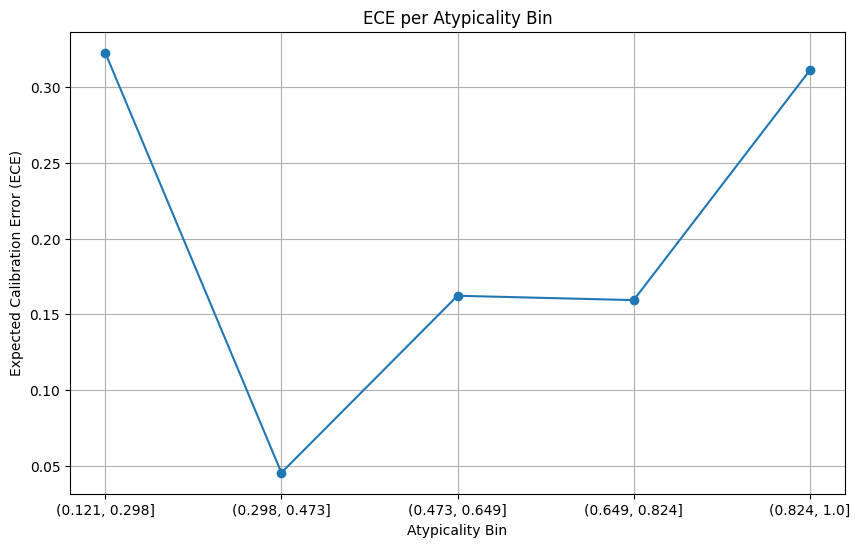

In [71]:
# Plotting the ECE per atypicality bin as a line chart
plt.figure(figsize=(10, 6))
plt.plot(ece_per_bin['atypicality_bin'], ece_per_bin['ECE'], marker='o', linestyle='-')
plt.xlabel('Atypicality Bin')
plt.ylabel('Expected Calibration Error (ECE)')
plt.title('ECE per Atypicality Bin')
plt.grid(True)
plt.show()

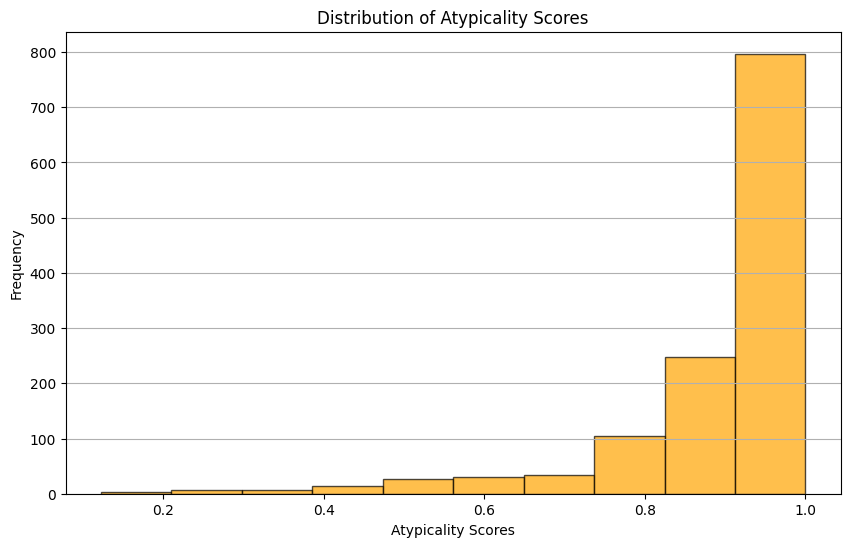

In [79]:
# Plotting the distribution of atypicality scores
plt.figure(figsize=(10, 6))
plt.hist(df['Atypicality'], bins=10, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Atypicality Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Atypicality Scores')
plt.grid(axis='y')
plt.show()

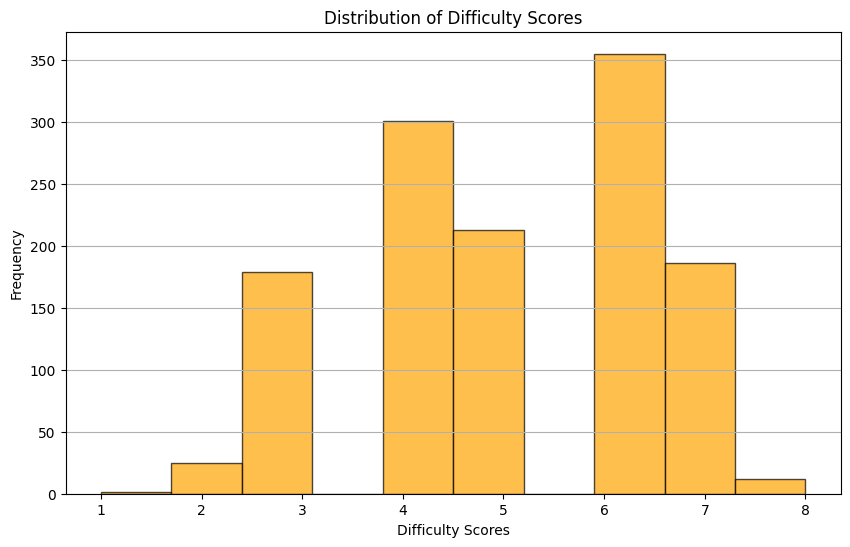

In [93]:
# Plotting the distribution of atypicality scores
plt.figure(figsize=(10, 6))
plt.hist(df['difficulty'], bins=10, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Difficulty Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Difficulty Scores')
plt.grid(axis='y')
plt.show()

In [94]:
df['vanilla'] = df['All Vanilla Confidence Scores'].apply(lambda x: x[0])
df['conf'] = df['All Confidence Scores'].apply(lambda x: x[0])

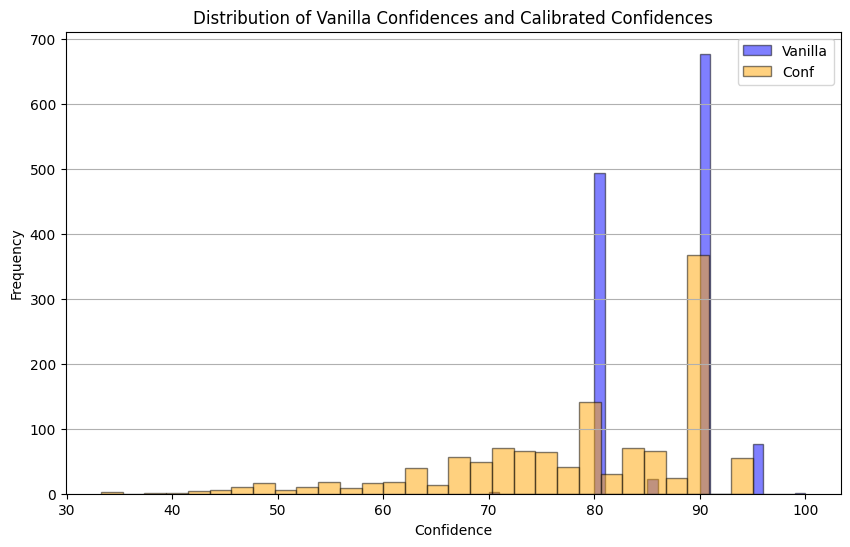

In [97]:
# Plotting the distributions of 'vanilla' and 'conf' on the same graph
plt.figure(figsize=(10, 6))
plt.hist(df['vanilla'], bins=30, color='blue', alpha=0.5, label='Vanilla', edgecolor='black')
plt.hist(df['conf'], bins=30, color='orange', alpha=0.5, label='Conf', edgecolor='black')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Vanilla Confidences and Calibrated Confidences')
plt.legend()
plt.grid(axis='y')
plt.show()

In [98]:
df['factor'] = df['conf'] / df['vanilla']

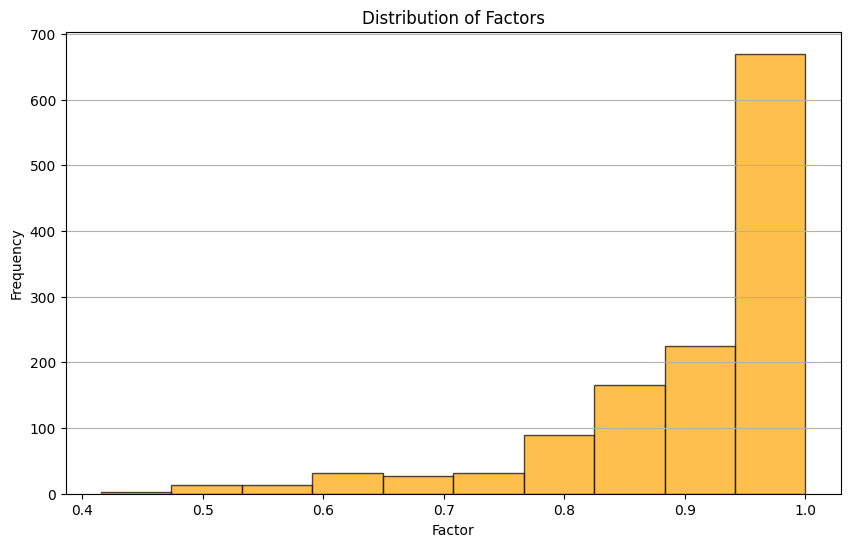

In [101]:
# Plotting the distribution of factors
plt.figure(figsize=(10, 6))
plt.hist(df['factor'], bins=10, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Factor')
plt.ylabel('Frequency')
plt.title('Distribution of Factors')
plt.grid(axis='y')
plt.show()

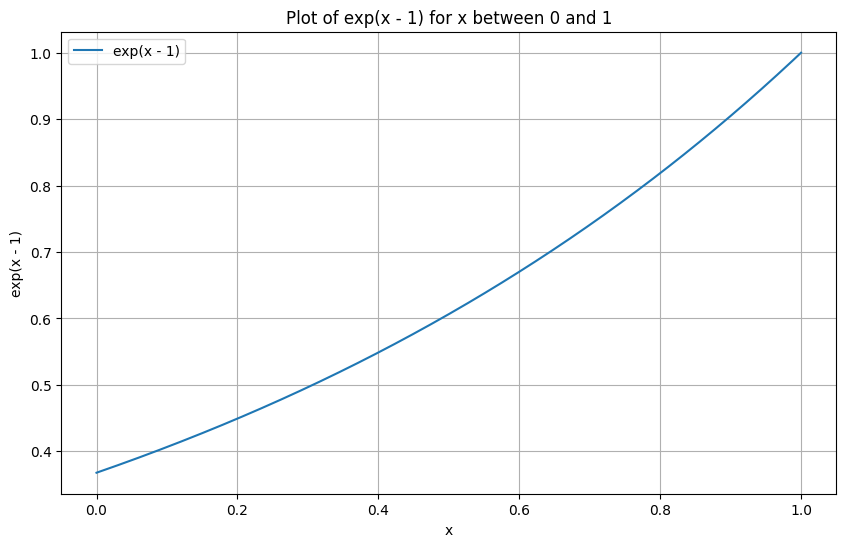

In [102]:
# Define the function exp(x - 1)
def func(x):
    return np.exp(x - 1)

# Define the range for x
x = np.linspace(0, 1, 500)
y = func(x)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='exp(x - 1)')
plt.xlabel('x')
plt.ylabel('exp(x - 1)')
plt.title('Plot of exp(x - 1) for x between 0 and 1')
plt.grid(True)
plt.legend()
plt.show()

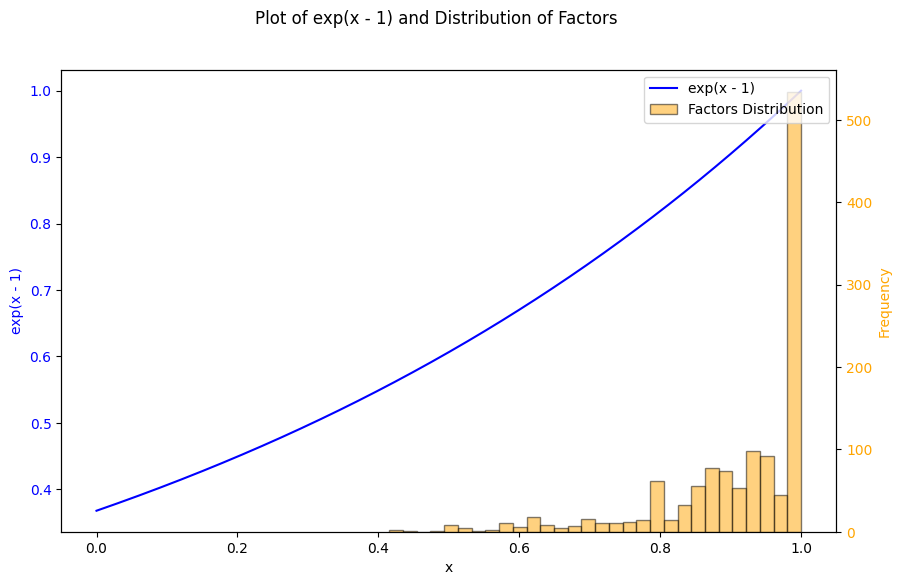

In [103]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the function exp(x - 1)
x = np.linspace(0, 1, 500)
y = np.exp(x - 1)
ax1.plot(x, y, label='exp(x - 1)', color='blue')
ax1.set_xlabel('x')
ax1.set_ylabel('exp(x - 1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a second y-axis for the factor distribution
ax2 = ax1.twinx()
ax2.hist(df['factor'], bins=30, color='orange', alpha=0.5, edgecolor='black', label='Factors Distribution')
ax2.set_ylabel('Frequency', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Plot of exp(x - 1) and Distribution of Factors')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()